In [1]:
import sys
import os

from nlp_datasets import YahooDataset
from nlp_datasets import BaseDataset
from nlp_datasets import WordSim353Dataset
from nlp_modeltrainers import BaseTrainerModule
from nlp_metrics import Metrics

import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.nn import Module, Linear, Embedding
from torch.utils.data import DataLoader

from scipy.stats import spearmanr
import fastwer
import re

import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords 

lem = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from pytorch_lightning import LightningModule

dev = 'cpu'
if torch.cuda.is_available():
    dev = "cuda:0"

device = torch.device(dev)

In [2]:
from utils.config import *
from utils.SubwordHash import subwordhash, Word_Preprocessor, Hash_Preprocessor
from utils.SubwordEmbedding import subwordembedding
from utils.replace_dict import rep
from utils.dict_freq import get_freq_dict

In [3]:
def semantic_eval(word_corpus, word_embedding, subword_hashes):
    spearman_corr = Metrics("Spearman")
    cosine_sim = Metrics("Cosine_Similarity")
    
    target_sim = np.array([])
    model_sim = np.array([])
    
    if isinstance(word_corpus[0], dict):
        keys = list(word_corpus[0])
    else:
        keys = range(3)
        
    for w in tqdm(word_corpus):
        sw1 = subword_hashes(w[keys[0]])
        sw2 = subword_hashes(w[keys[1]])
        subword_embed = word_embedding.subword_embedding(torch.tensor([sw1,sw2], dtype = torch.long))
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).unsqueeze(1).detach().numpy()
        cos_sim = cosine_sim(word_embed[0], word_embed[1])["Cosine_Similarity"]
        model_sim = np.append(model_sim, cos_sim)
        target_sim = np.append(target_sim, w[keys[2]])
    model_sim = np.expand_dims(model_sim, axis = 0)
    target_sim = np.expand_dims(target_sim, axis = 0)
    
    spearman_coef = spearman_corr(model_sim, target_sim)["Spearman"]
#     spearman_coef.append(correlation)
#         target_sim.append(w[keys[2]])
#     print('model_sim: ', model_sim)
#     print('target_sim: ', target_sim)
    print('spearman_coef: ', spearman_coef)
    plt.figure(figsize=[20,5])
#     plt.plot(spearman_coef)
    plt.plot(model_sim[0])
    plt.plot(target_sim[0])
    plt.grid()
    plt.show()
    

In [4]:
word_dataset = YahooDataset(max_samples=max_samples, local_dir="../datasets/small_yahoo_dataset_text")
freq_dict = get_freq_dict(word_dataset.train)

100%|████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:03<00:00, 283.56it/s]


In [5]:
train_preprocessor = Word_Preprocessor(freq_dict = freq_dict, train = True)
word_dataset.train.set_preprocessor(train_preprocessor)

preprocessor = Word_Preprocessor(freq_dict = freq_dict, train = False)
word_dataset.val.set_preprocessor(preprocessor)
word_dataset.test.set_preprocessor(preprocessor)

In [6]:
subword_hashes = subwordhash(word_dataset.train)

word_num = subword_hashes.word_num
max_sw_hash_len = subword_hashes.max_hash
max_sample_len = subword_hashes.max_sample
print(max_sw_hash_len)
print(max_sample_len)

100%|████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:01<00:00, 512.64it/s]


356
811


In [7]:
def similarity_eval(word_corpus, word_embedding, subword_hashes):
    mae = []
    less = []
    more = []
    similarities = []
    target_similarities = []
    if isinstance(word_corpus[0], dict):
        keys = list(word_corpus[0])
    else:
        keys = range(len(word_corpus[0]))
    for w in tqdm(word_corpus):
        w1 = subword_hashes(w[keys[0]])
        w2 = subword_hashes(w[keys[1]])
        subword_embed = word_embedding.subword_embedding(torch.tensor([w1,w2],dtype = torch.long)).to(device)
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).unsqueeze(1).to(device)
        model_sim = float(F.cosine_similarity(word_embed[0], word_embed[1]))
        similarities.append(model_sim)
        target_sim = 1 - fastwer.score_sent(w[0], w[1], char_level = True)/100
        target_similarities.append(target_sim)
        mae.append(abs(target_sim - model_sim))
        if target_sim - model_sim >=0:
            less.append(abs(target_sim - model_sim))
        elif target_sim - model_sim < 0:
            more.append(abs(target_sim - model_sim))
            
    print(f"MAE: {np.mean(mae)}")
    print(f"MAE (More): {np.mean(more)}")
    print(f"MAE (Less): {np.mean(less)}")
    plt.figure(figsize=[20,5])
    plt.plot(similarities)
    plt.plot(target_similarities)
    plt.grid()
    plt.show()


In [8]:
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/words_corpus.txt", "r") as f:
    words_corpus = [line.split(":") for line in f.read().split("\n")]
    
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/anagram_corpus.txt", "r") as f:
    anagram_corpus = [line.split(":") for line in f.read().split("\n")]
    
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/misspellings_corpus.txt", "r") as f:
    misspellings_corpus = [line.split(":") for line in f.read().split("\n")]

In [9]:
misspellings_corpus[0]

['abaout', 'about', '0.833333']

In [10]:
WS353ds = WordSim353Dataset(max_samples = max_samples, local_dir = "../datasets/WordSim353Dataset")
word_corpus = WS353ds.test

In [11]:
word_embedding = subwordembedding(num_embeddings = num_emb, embedding_dim = emb_dim, device = device, padding_idx = 0)
word_embedding.load_state_dict(torch.load(emb_path))
print(f'Loaded model: {emb_path}')
print(word_embedding.num_embeddings)

Loaded model: ../Trained_Models/SubwordEmbedding/trained_model/trained_model_100d_noisedist_100e_3w_10000sample_min1_culled_noURL_lemmatized
2000001


100%|████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:02<00:00, 193.30it/s]


MAE: 0.41927957838328156
MAE (More): 0.15979526937007904
MAE (Less): 0.41979751113580294


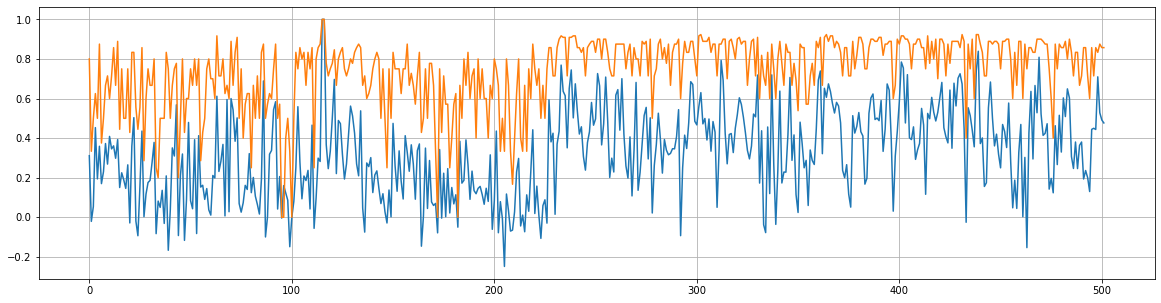

In [12]:
similarity_eval(misspellings_corpus, word_embedding, subword_hashes)
# similarity_eval(misspellings_corpus, latesum_word_embedding, subword_hashes)

100%|██████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 557.03it/s]

spearman_coef:  -0.11820728291316528


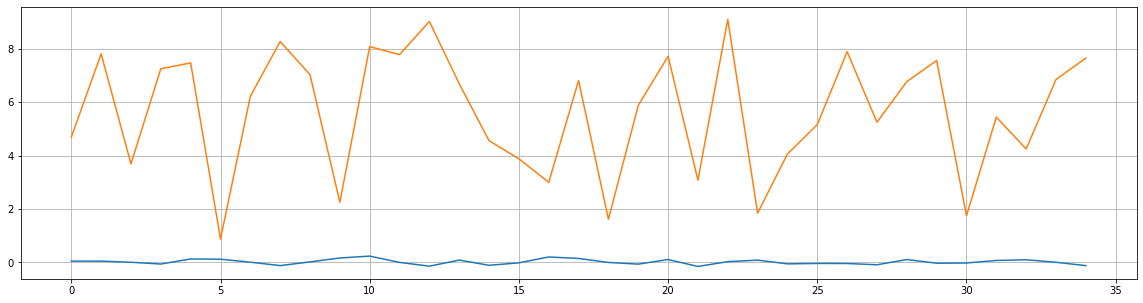

In [13]:
semantic_eval(word_corpus, word_embedding, subword_hashes)
# semantic_eval(word_corpus, latesum_word_embedding, subword_hashes)

##### a = Metrics('')

In [14]:
misspellings_corpus[0]

['abaout', 'about', '0.833333']

In [15]:
a = np.array([])
a = np.append(a,10)
a = np.append(a,20)
a

array([10., 20.])